In [1]:
# HW 3 - NYT Articles Notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("nyt.csv")
print(df.head())
print(df.shape)

                                                text   label
0  (reuters) - carlos tevez sealed his move to ju...  sports
1  if professional pride and strong defiance can ...  sports
2  palermo, sicily — roberta vinci beat top-seede...  sports
3  spain's big two soccer teams face a pair of it...  sports
4  the argentine soccer club san lorenzo complete...  sports
(11519, 2)


Part 1: Bag Of Words (20 points):

(a) binary-valued vector

(b) frequency vector

(c) tf-idf vector

In [3]:
# Initialize Logistic Regression and split data 80-10-10

# Define X and y 
X = df["text"].tolist()
y = df["label"].tolist()

# Initialize Logistic Regression
lr = LogisticRegression()

# 90 - 10 split on entire dataset to get testing dataset (10%) and train-val dataset (90%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split the train-val dataset (90%) into an 80 - 10 split, (80% train, 10% val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(10/90), random_state=42)

In [39]:
# (a)binary-valued vector
# TODO

# Initialize CountVectorizer and specify Binary = True
binary_vec = CountVectorizer(binary=True)

# Fit transform the tranining data and transform val and test data
X_train_bvec = binary_vec.fit_transform(X_train)

X_val_bvec = binary_vec.transform(X_val)
X_test_bvec = binary_vec.transform(X_test)

# Fit Linear Regression model and generate predictions based on X_val
lr.fit(X_train_bvec, y_train)
preds_bvec = lr.predict(X_val_bvec)
binary_macro_f1 = f1_score(y_val, preds_bvec, average='macro')

# Find macro f1 score (since this is binary classification)
print(f"Macro F1 Score: {binary_macro_f1}")

Macro F1 Score: 0.9533235897080291


In [40]:
# (b) frequency vector
# TODO

# Initialize CountVectorizer and set Binary = False for frequency/ count vectors
count_vec = CountVectorizer(binary=False)

# Fit transform the tranining data and transform val and test data
# change bvec (binary vector) to fvec (frequency vector)
X_train_fvec = count_vec.fit_transform(X_train)

X_val_fvec = count_vec.transform(X_val)
X_test_fvec = count_vec.transform(X_test)

# Fit Linear Regression model and generate predictions based on X_val
lr.fit(X_train_fvec, y_train)
preds_fvec = lr.predict(X_val_fvec)
frequency_macro_f1 = f1_score(y_val, preds_fvec, average='macro')

# Find macro f1 score (since this is binary classification)
print(f"Macro F1 Score: {frequency_macro_f1}")

Macro F1 Score: 0.9618116952759584


In [41]:
# (c) tf-idf vector
# TODO

# Initialize TfidfVectorizer, lowercase all words, and set stop words to english
tfidf_vec = TfidfVectorizer(stop_words="english", lowercase=True)

# Fit transform the tranining data and transform val and test data
# change bvec (binary vector)/ fvec (frequency vector) to tfidf
X_train_tfidf = tfidf_vec.fit_transform(X_train)

X_val_tfidf = tfidf_vec.transform(X_val)
X_test_tfidf = tfidf_vec.transform(X_test)

# Fit Linear Regression model and generate predictions based on X_val
lr.fit(X_train_tfidf, y_train)
preds_tfidf = lr.predict(X_val_tfidf)
tfidf_macro_f1 = f1_score(y_val, preds_tfidf, average='macro')

# Find macro f1 score (since this is binary classification)
print(f"Macro F1 Score: {tfidf_macro_f1}")

Macro F1 Score: 0.9633348981778518


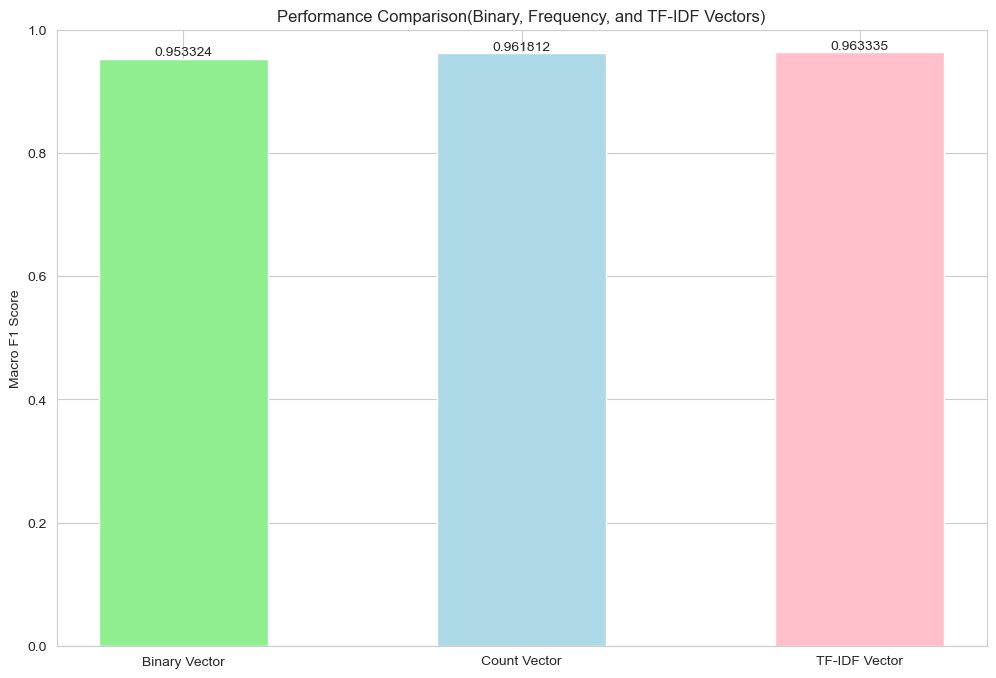

In [45]:
# Plot performance

scores = [binary_macro_f1, frequency_macro_f1, tfidf_macro_f1]
methods = ["Binary Vector", "Count Vector", "TF-IDF Vector"]

x = np.arange(len(methods))
bar_width = 0.5

plt.figure(figsize=(12,8))
bar_plot = plt.bar(x, scores, width=bar_width, color=["lightgreen", "lightblue", "pink"])
plt.title("Performance Comparison(Binary, Frequency, and TF-IDF Vectors)")
plt.xticks(x, methods)
plt.ylim(0,1)
plt.ylabel("Macro F1 Score")
plt.bar_label(bar_plot, label_type="edge")
plt.show()

Part 2: Word2Vec (20 points):

In [28]:
# TODO

# Word2Vec
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score

# Tokenize sentences (lowercase and split)
def tokenize(text):
    return text.lower().split()

# Apply tokenization to X train, val and test
X_train_token = [tokenize(sentence) for sentence in X_train]
X_val_token = [tokenize(sentence) for sentence in X_val]
X_test_token = [tokenize(sentence) for sentence in X_test]

# Initialize word2vec model and set dimensions = 100
wv = Word2Vec(
    sentences=X_train_token,
    vector_size=100
)

# Iterate through every sentance in the dataset and convert into a sincle vector
# Essentially averages all word vectors into a single 100 dimension document embedding
def tokens_to_vector(token, model, size=100):
    words = [word for word in token if word in model.wv]
    if not words:
        return np.zeros(size)
    return np.mean(model.wv[words], axis=0)

# Apply token to vector onto X train, val and test
X_train_vec = np.vstack([tokens_to_vector(tokens, wv) for tokens in X_train_token])
X_val_vec   = np.vstack([tokens_to_vector(tokens, wv) for tokens in X_val_token])
X_test_vec  = np.vstack([tokens_to_vector(tokens, wv) for tokens in X_test_token])

# Train logistic regression model and calculate f1 score
lr.fit(X_train_vec, y_train)
word2vec_pred = lr.predict(X_val_vec)

word2vec_macro_f1 = f1_score(y_val, word2vec_pred, average='macro')
word2vec_micro_f1 = f1_score(y_val, word2vec_pred, average='micro')
word2vec_accuracy = accuracy_score(y_val, word2vec_pred)

print(f"Macro F1 Score: {word2vec_macro_f1}")
print(f"Micro F1 Score: {word2vec_micro_f1}")
print(f"Accuracy Score: {word2vec_accuracy}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Macro F1 Score: 0.9443507078395257
Micro F1 Score: 0.9765625
Accuracy Score: 0.9765625


In [29]:
# GloVe

import gensim.downloader as api

# Initialize GloVe model
glove_model = api.load("glove-wiki-gigaword-100") # glove-wiki is a pretrained model, trained on wikipidia and gigword

# Convert tokens into vectors
def to_glove_vector(tokens, model, size=100):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(size) # defualt to 0 for unknown words
    return np.mean(vectors, axis=0)
# Loops through tokenized sentences and only keeps words that exist in the GloVe model's vocab, else set as 0

# Apply conversion to X train, test, and val
X_train_vec = np.vstack([to_glove_vector(tokens, glove_model) for tokens in X_train_token])
X_val_vec   = np.vstack([to_glove_vector(tokens, glove_model) for tokens in X_val_token])
X_test_vec  = np.vstack([to_glove_vector(tokens, glove_model) for tokens in X_test_token])

#  Train logistic regression model and calculate f1 score
lr.fit(X_train_vec, y_train)
glove_pred = lr.predict(X_val_vec)

glove_macro_f1 = f1_score(y_val, glove_pred, average='macro')
glove_micro_f1 = f1_score(y_val, glove_pred, average='micro')
glove_accuracy = accuracy_score(y_val, glove_pred)

print(f"Macro F1 Score: {glove_macro_f1}")
print(f"Micro F1 Score: {glove_micro_f1}")
print(f"Accuracy Score: {glove_accuracy}")

Macro F1 Score: 0.9416854878911732
Micro F1 Score: 0.9748263888888888
Accuracy Score: 0.9748263888888888


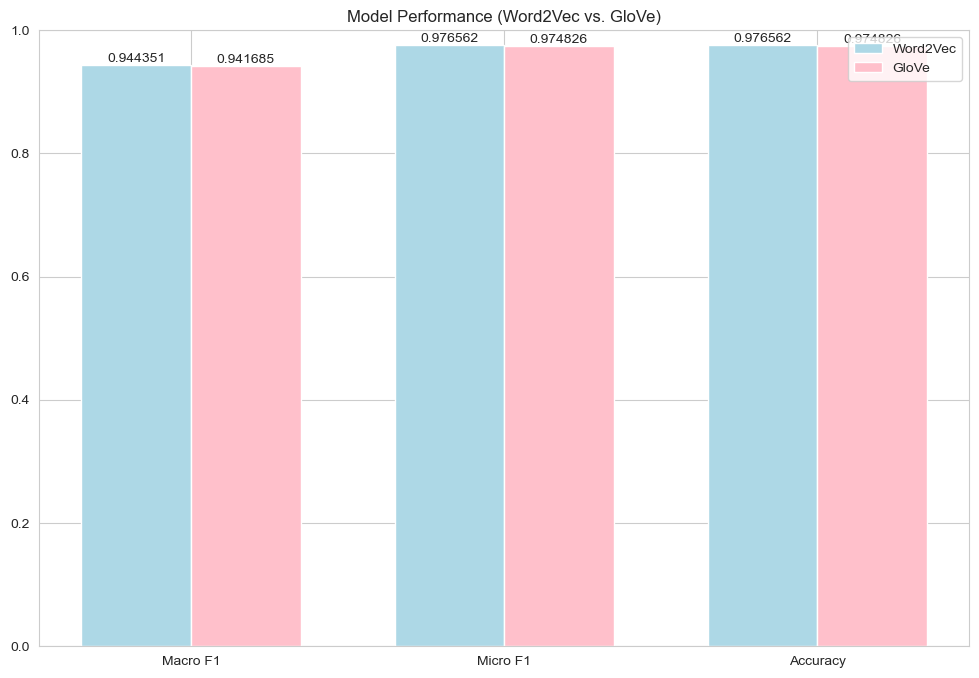

In [ ]:
# Bar chart (Word2Vec vs. GloVe)

word2vec_scores = [word2vec_macro_f1, word2vec_micro_f1, word2vec_accuracy]
glove_scores = [glove_macro_f1, glove_micro_f1, glove_accuracy]
metrics = ["Macro F1", "Micro F1", "Accuracy"]

x = np.arange(len(metrics))
bar_width = 0.35

plt.figure(figsize=(12,8))
word2vec_plot = plt.bar(x - bar_width/2, word2vec_scores, label="Word2Vec", width=bar_width, color="lightblue")
glove_plot = plt.bar(x + bar_width/2, glove_scores, label="GloVe", width=bar_width, color="pink")

plt.title("Model Performance (Word2Vec vs. GloVe)")
plt.xticks(x, metrics)
plt.ylim(0,1)
plt.legend()
plt.bar_label(word2vec_plot, label_type="edge")
plt.bar_label(glove_plot, label_type="edge")
plt.show()

Part 3: BERT (20 points):

In [9]:
# Perform train-test-split again but this time encode label values using label encoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

# Define X and y 
X = df["text"].tolist()
y = df["label"].tolist()

# Initialize Logistic Regression
lr = LogisticRegression()

# 90 - 10 split on entire dataset to get testing dataset (10%) and train-val dataset (90%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split the train-val dataset (90%) into an 80 - 10 split, (80% train, 10% val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(10/90), random_state=42)

In [10]:
# TODO
import torch
from transformers import get_linear_schedule_with_warmup
from transformers.models.bert import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# Initialize Bert Tokenizer - load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define custom dataset
class TextData(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
    
    # Returns the number of samples
    def __len__(self):
        return len(self.texts)
    
    # Converts items into BERT compatable format
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Apply tokenizer to convert text into input ids for BERT
        tokenized_data = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=64, # set maximum length to 64
            return_tensors="pt" # returns pytorch tensors
        )

        item = {key: val.squeeze(0) for key,val in tokenized_data.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long) # Add label to the returned dictionary
        return item
    
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3 # set for 3 output classes (sports, politics, business)
)

# Uses GPU if available, if not default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Apply custom dataset configurations to train, val, and test data
train_data = TextData(X_train, y_train, tokenizer)
val_data = TextData(X_val, y_val, tokenizer)
test_data = TextData(X_test, y_test, tokenizer)

# Create batches of tokenized data
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)
test_loader = DataLoader(test_data, batch_size=16)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.optim import AdamW # Use AdamW 

# Define 3 epoch
# Use adam as optimization algorithm
epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)

# Calculate total number of gradient updates
total_steps = len(train_loader)*epochs

# Decrease lr gradually
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [12]:
model.train() # Set to training mode

# Define training loop - loops through per epoch per batch
# Calculates and minimizes gradients
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/ {epochs}")
    
    # Use tqdm for progress bar
    for batch in tqdm(train_loader):
        
        batch = {k: v.to(device) for k, v in batch.items()} # move inputs to GPU

        # Computs outputs and loss
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward() # backpropagation
        optimizer.step() # update model weights
        scheduler.step() # adjust lr
        optimizer.zero_grad() # reset gradient and repeat until loop finishes

    print(f"Epoch {epoch+1} loss: {loss.item():.2f}")

Epoch 1/ 3


  0%|          | 0/576 [00:00<?, ?it/s]

Epoch 1 loss: 0.01
Epoch 2/ 3


  0%|          | 0/576 [00:00<?, ?it/s]

Epoch 2 loss: 0.01
Epoch 3/ 3


  0%|          | 0/576 [00:00<?, ?it/s]

Epoch 3 loss: 0.00


In [13]:
model.eval() # Set model to evaluation mode

# Create a list to store predictions and labels
predictions = []
labels = []

# Loops through model and extracts predictions and outputs. Appends to predictions and labels list
with torch.no_grad(): # Diable gradient updates/ calculations for evaluation
    for batch in test_loader:
        batch = {k: v.to(device) for k,v in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits # extract raw outputs
        preds = torch.argmax(logits, dim=1) # extract predicted class

        # Moves to CPU and stores data in list
        predictions.extend(preds.cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

In [ ]:
# Calculate evaluation metrics (accuracy, f1_macro, and f1_micro)
accuracy = accuracy_score(labels, predictions)
macro_f1 = f1_score(labels, predictions, average="macro")
micro_f1 = f1_score(labels, predictions, average="micro")

print(round(accuracy, 4))
print(round(macro_f1, 4))
print(round(micro_f1, 4))

0.9705
0.9433
0.9705


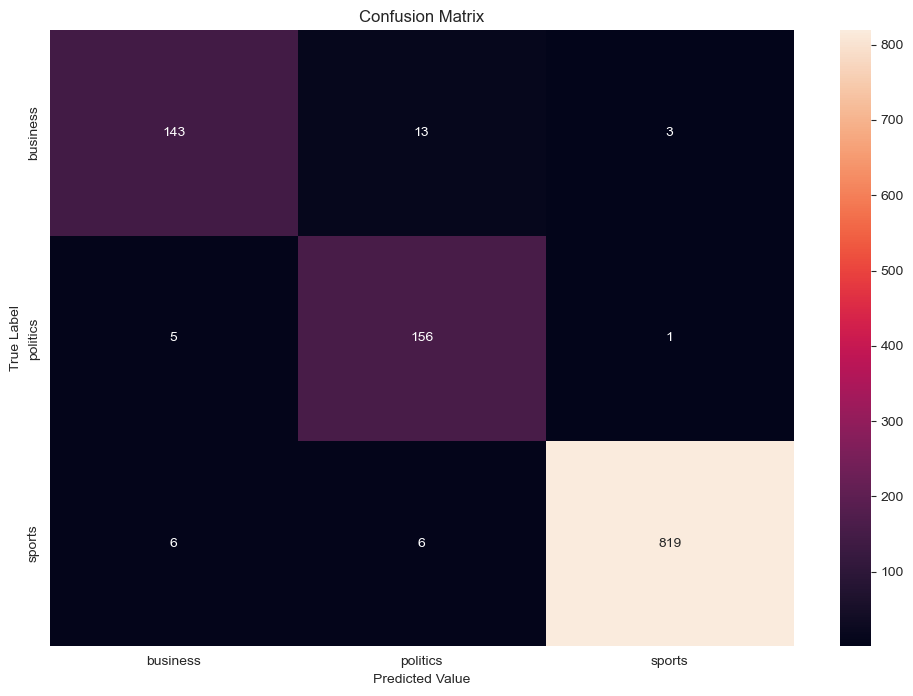

In [ ]:
# Plot confusion matrix 
from sklearn.metrics import confusion_matrix
class_names = le.inverse_transform([0,1,2])

plt.figure(figsize=(12,8))
matrix = confusion_matrix(labels, predictions)

sns.heatmap(matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Value")
plt.show()

In [25]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       159
           1       0.89      0.96      0.93       162
           2       1.00      0.99      0.99       831

    accuracy                           0.97      1152
   macro avg       0.94      0.95      0.94      1152
weighted avg       0.97      0.97      0.97      1152



Part 4: Summary of results / Reflection
## TODO

[BERT]
- Based on Accuracy and F1 Micro Score, 97.05% of all predictions were correctly classified. Similarly,
- Based on Macro F1 Score of 94.36%, it suggests all classess performed relatively well.
- The gap between Macro F1 and Micro F1 suggests that there could be some class imbalance 

[GloVe & Word2Vec]
- Both GloVe and Word2Vec scored roughly the same: 0.94
- This indicates that both models performed well on every class (politics, business, and sports), and not just one class.
- When examining Macro and Micro F1 scores and Accuracy, both GloVe and Word2Vec have similar scores accross the board, with around ~0.02-0.04 percent difference 

[Binary-Valued Vector, Frequency Vector, & TF-IDF Vector]
- All three models performed around the same when looking at Macro F1 score ~ 0.95-0.96
- Binary-Valued Vector looks at how whether a word appears while Frequency Vector looks at the raw word count
- TF-IDF Vector had the best performance out of the three and introduces upweights on rare words and downweights on common words. This improves classification accuracy.